In [1]:
import sys
sys.path.append("Methods/EWC/old")

In [2]:
from lib.abstract_torch import get_device, get_optimizer, get_loss
from lib.benchmark_generator import PermutedMNIST
from lib.models import ANN
from lib.train import train
from lib.test import test
from lib.visualize import vizualize_loss_hists, visualize_accs_matrix, visualize_avg_acc_curve

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from avalanche.training.supervised import EWC
from avalanche.training.plugins import EWCPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/data"

In [4]:
device = get_device(1)

## Set parameters

In [5]:
# Benchmark parameter
num_tasks = 3
train_percentage = 0.3

# EWC parameter
ewc_lambda = 400

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 1000
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 1e-3

## Reproducibility

In [6]:
random_seed = 88

## Get p-MNIST benchmark

In [7]:
benchmark = PermutedMNIST(n_experiences=num_tasks, train_percentage=train_percentage, difficulty="hard", seed=random_seed)

## Define model

In [8]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

## Train with EWC

In [9]:
optimizer = get_optimizer(optimizer_name, model)

In [10]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
    device=device
)

print((ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data> 1e-6).sum())

In [11]:
model.fc1.weight

Parameter containing:
tensor([[ 1.9505e-02,  1.3839e-02,  2.3594e-02,  ..., -2.4597e-02,
          3.3790e-02, -2.4704e-03],
        [ 6.1313e-03,  2.6851e-02, -1.5784e-03,  ..., -7.8577e-03,
         -3.4669e-02,  3.2368e-02],
        [-2.6674e-02, -6.6836e-03,  6.3991e-03,  ...,  3.5664e-02,
          6.5224e-03, -2.6120e-02],
        ...,
        [ 2.8606e-02, -8.2839e-04, -1.6372e-02,  ..., -2.5799e-02,
         -6.6854e-03, -2.7618e-02],
        [ 3.5563e-02, -2.6682e-02,  1.7235e-02,  ...,  3.6278e-05,
          1.1521e-02,  2.2595e-02],
        [ 3.2441e-02,  1.0035e-02,  1.1145e-02,  ...,  3.3809e-02,
          2.3411e-02,  2.8478e-02]], device='cuda:1', requires_grad=True)

In [12]:
experience = benchmark.train_stream[0]
ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data

tensor([[8.0858e-08, 1.4753e-07, 4.1782e-07,  ..., 8.0609e-08, 9.2233e-07,
         1.5826e-07],
        [1.0734e-07, 2.2515e-07, 4.9685e-07,  ..., 1.0688e-07, 9.3914e-07,
         3.4336e-07],
        [1.0856e-07, 5.8794e-07, 4.4930e-07,  ..., 1.0740e-07, 1.3789e-06,
         2.9704e-07],
        ...,
        [5.2204e-08, 2.4077e-07, 1.8232e-07,  ..., 5.1761e-08, 6.6474e-07,
         7.3276e-08],
        [4.6957e-08, 2.3453e-07, 3.1081e-07,  ..., 4.6787e-08, 4.3586e-07,
         9.3444e-08],
        [1.3676e-07, 4.4326e-07, 6.6668e-07,  ..., 1.3613e-07, 1.8650e-06,
         1.9247e-07]], device='cuda:1')

In [13]:
results = []
for experience in benchmark.train_stream :
    ewc.train(experience)
    print(len(ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)))
    results.append(ewc.eval(benchmark.test_stream))

-- >> Start of training phase << --
100%|██████████| 141/141 [00:01<00:00, 72.12it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8289
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9625
100%|██████████| 141/141 [00:01<00:00, 71.95it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9511
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9875
  3%|▎         | 4/141 [00:00<00:03, 41.63it/s]

KeyboardInterrupt: 

## Visualize results

In [ ]:
test_accs_matrix = np.zeros((num_tasks,num_tasks))
for i,r in enumerate(results) :
    for j in range(num_tasks) :
        test_accs_matrix[i][j] = r[f'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{j}']*100

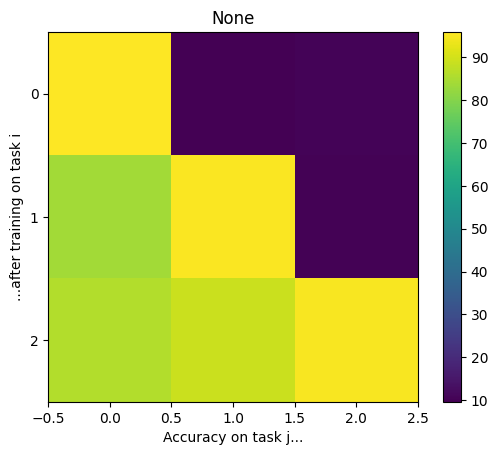

In [ ]:
visualize_accs_matrix(test_accs_matrix)

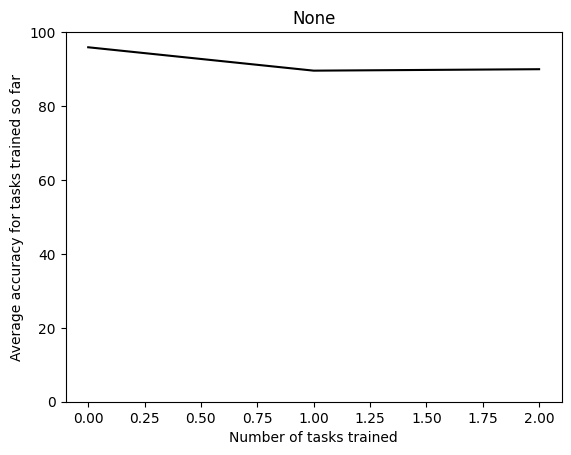

In [ ]:
visualize_avg_acc_curve(test_accs_matrix)